In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import gc
import keras
from keras import backend as K
from keras.utils import plot_model
from keras.regularizers import l2
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1057: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1057: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load and Preprocessing the CIFAR10 Dataset

In [2]:
# Create label and digit map
digit2labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 
                5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
label2digits = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 
                'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [3]:
# Download the CIFAR10 dataset from Kaggle: https://www.kaggle.com/c/cifar-10
# Unzip the download data train.7z and test.7z such that 
# training images is in ./data/train/ and test images are in ./data/test/

preprocessing = False  # whether or not to read the images and save to numpy array
if preprocessing is True:
    train_label = pd.read_csv('./data/trainLabels.csv')['label'].values
    test_label = pd.read_csv('./data/sampleSubmission.csv')
    
    # process the training set, totally 50,000 images
    train_x = []
    train_y = []
    num = 50000
    for i in range(num):
        img = imread('./data/train/{0:d}.png'.format(i + 1))
        label = train_label[i]
        train_x.append(img)
        train_y.append(label)
        
    # process the test set, totally 300,000 images
    test_x = []
    num = 300000
    for i in range(num):
        img = imread('./data/test/{0:d}.png'.format(i + 1))
        test_x.append(img)
        
    # Transform to numpy array
    train_x = np.array(train_x, dtype='uint8')
    train_y = np.array(list(map(lambda x: label2digits[x], train_y))).reshape((-1, 1))
    test_x = np.array(test_x, dtype='uint8')

    # Save to disk
    np.save('./data/train_x.npy', train_x)
    np.save('./data/train_y.npy', train_y)
    np.save('./data/test_x.npy', test_x)

In [4]:
# Load CIFAR10 dataset instead of using the data from Kaggle
(train_x, train_y), (val_x, val_y) = cifar10.load_data()

# Read test images
test_x = np.load('./data/test_x.npy')

# Transform data format
train_x = train_x.astype('float32') / 255
val_x = val_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

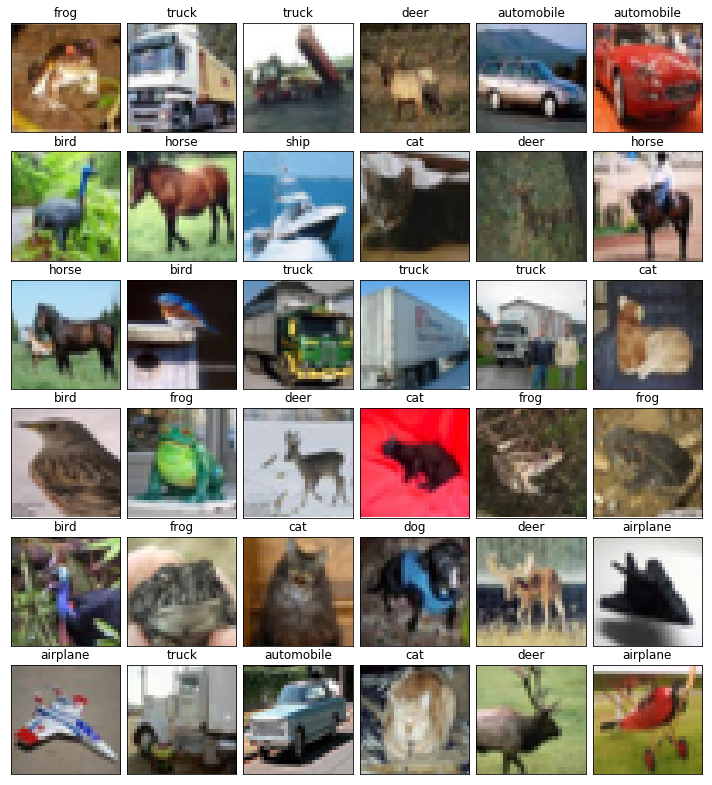

In [5]:
# Visualize the CIFAR10 dataset
nrows, ncols = 6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 11))
for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        ax[row][col].imshow(train_x[idx])
        ax[row][col].set_title(digit2labels[train_y[idx][0]])
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
plt.tight_layout(h_pad=0, w_pad=0)
fig.savefig('./result/snapshot.png', dpi=200)
plt.show()

In [6]:
# Subtrack pixel mean
train_x_mean = np.mean(train_x, axis=0)
train_x -= train_x_mean
val_x -= train_x_mean
test_x -= train_x_mean

# Convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 10)
val_y = keras.utils.to_categorical(val_y, 10)

# Get the info about the dataset
print('Train:\t\t', train_x.shape, val_y.shape)
print('Valdation:\t', val_x.shape, val_y.shape)
print('Test:\t\t', test_x.shape)

Train:		 (50000, 32, 32, 3) (10000, 10)
Valdation:	 (10000, 32, 32, 3) (10000, 10)
Test:		 (300000, 32, 32, 3)


# Build VGG Model

VGG is a easy-to-understand CNN model built for ImageNet recognition. Here, the model is built based on the original paper
* [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In [7]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def vgg(input_shape=(32, 32, 3), classes=10):
    """ Define VGG model using Keras API """
    model = Sequential(name='VGG')
    # Block # 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv1'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block1_pool'))
    model.add(Dropout(rate=0.25, name='block1_dropout'))
    
    # Block # 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block2_pool'))
    model.add(Dropout(rate=0.3, name='block2_dropout'))
    
    # Block # 3
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block3_pool'))
    model.add(Dropout(rate=0.35, name='block3_dropout'))
    
    # Fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(units=256, activation='relu', name='fc1'))
    model.add(Dropout(rate=0.5, name='fc1_dropout'))
    model.add(Dense(units=128, activation='relu', name='fc2'))
    model.add(Dropout(rate=0.5, name='fc2_dropout'))
    model.add(Dense(units=classes, activation='softmax', name='prediction'))
    
    return model

In [8]:
# To reproduce the result, refer to https://keras.io/getting-started/faq/
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [9]:
# Create VGG model
input_shape = (32, 32, 3)
vgg_model = vgg(input_shape=input_shape, classes=10)

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block1_dropout (Dropout)     (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0         
__________

In [10]:
# Create optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg_checkpoint.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Real-time data augumentation
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0.0,
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

# Fit generator on training set
datagen.fit(train_x)

# Fit the model on the batches
vgg_history = vgg_model.fit_generator(datagen.flow(train_x, train_y, batch_size=128),
                                      validation_data=(val_x, val_y), epochs=200, 
                                      verbose=2, workers=4, callbacks=callbacks)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
 - 21s - loss: 1.8900 - acc: 0.2791 - val_loss: 1.5250 - val_acc: 0.4069
Epoch 2/200
Learning rate:  0.001
 - 19s - loss: 1.4983 - acc: 0.4499 - val_loss: 1.2410 - val_acc: 0.5472
Epoch 3/200
Learning rate:  0.001
 - 20s - loss: 1.3262 - acc: 0.5236 - val_loss: 1.0776 - val_acc: 0.6113
Epoch 4/200
Learning rate:  0.001
 - 20s - loss: 1.2091 - acc: 0.5693 - val_loss: 0.9871 - val_acc: 0.6523
Epoch 5/200
Learning rate:  0.001
 - 20s - loss: 1.1294 - acc: 0.6027 - val_loss: 0.9965 - val_acc: 0.6491
Epoch 6/200
Learning rate:  0.001
 - 20s - loss: 1.0651 - acc: 0.6290 - val_loss: 0.8520 - val_acc: 0.6965
Epoch 7/200
Learning rate:  0.001
 - 20s - loss: 1.0026 - acc: 0.6506 - val_loss: 0.8734 - val_acc: 0.6950
Epoch 8/200
Learning rate:  0.001
 - 20s - loss: 0.9721 - acc: 0.6661 - val_loss: 0.7787 - val_acc: 0.7273
Epoch 9/200
Learning rate:  0.001
 - 20s - loss: 0.9404 - acc: 0.6787 - val_loss: 0.7679 - val_acc: 0.7299
Epoch 10/200
Le

Epoch 77/200
Learning rate:  0.001
 - 20s - loss: 0.5965 - acc: 0.8038 - val_loss: 0.5335 - val_acc: 0.8230
Epoch 78/200
Learning rate:  0.001
 - 20s - loss: 0.5996 - acc: 0.8035 - val_loss: 0.5551 - val_acc: 0.8160
Epoch 79/200
Learning rate:  0.001
 - 20s - loss: 0.6006 - acc: 0.8032 - val_loss: 0.5792 - val_acc: 0.8116
Epoch 80/200
Learning rate:  0.001
 - 20s - loss: 0.5965 - acc: 0.8057 - val_loss: 0.5334 - val_acc: 0.8252
Epoch 81/200
Learning rate:  0.001
 - 20s - loss: 0.6019 - acc: 0.8032 - val_loss: 0.5354 - val_acc: 0.8180
Epoch 82/200
Learning rate:  0.0001
 - 20s - loss: 0.5484 - acc: 0.8206 - val_loss: 0.4945 - val_acc: 0.8394
Epoch 83/200
Learning rate:  0.0001
 - 20s - loss: 0.5321 - acc: 0.8268 - val_loss: 0.4942 - val_acc: 0.8400
Epoch 84/200
Learning rate:  0.0001
 - 20s - loss: 0.5251 - acc: 0.8269 - val_loss: 0.4968 - val_acc: 0.8386
Epoch 85/200
Learning rate:  0.0001
 - 20s - loss: 0.5110 - acc: 0.8317 - val_loss: 0.4821 - val_acc: 0.8457
Epoch 86/200
Learning ra

 - 20s - loss: 0.4650 - acc: 0.8465 - val_loss: 0.4660 - val_acc: 0.8487
Epoch 153/200
Learning rate:  1e-05
 - 20s - loss: 0.4643 - acc: 0.8459 - val_loss: 0.4605 - val_acc: 0.8502
Epoch 154/200
Learning rate:  1e-05
 - 20s - loss: 0.4586 - acc: 0.8476 - val_loss: 0.4628 - val_acc: 0.8503
Epoch 155/200
Learning rate:  1e-05
 - 20s - loss: 0.4606 - acc: 0.8487 - val_loss: 0.4596 - val_acc: 0.8504
Epoch 156/200
Learning rate:  1e-05
 - 20s - loss: 0.4586 - acc: 0.8482 - val_loss: 0.4636 - val_acc: 0.8499
Epoch 157/200
Learning rate:  1e-05
 - 20s - loss: 0.4617 - acc: 0.8485 - val_loss: 0.4595 - val_acc: 0.8509
Epoch 158/200
Learning rate:  1e-05
 - 20s - loss: 0.4633 - acc: 0.8484 - val_loss: 0.4597 - val_acc: 0.8506
Epoch 159/200
Learning rate:  1e-05
 - 20s - loss: 0.4601 - acc: 0.8484 - val_loss: 0.4596 - val_acc: 0.8510
Epoch 160/200
Learning rate:  1e-05
 - 20s - loss: 0.4657 - acc: 0.8458 - val_loss: 0.4614 - val_acc: 0.8496
Epoch 161/200
Learning rate:  1e-05
 - 20s - loss: 0.46

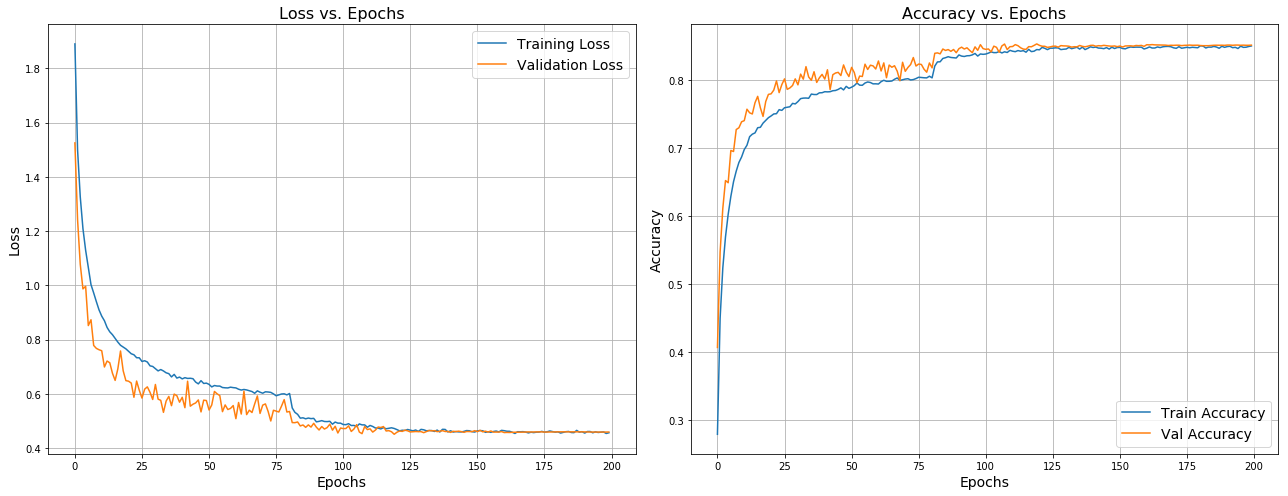

In [11]:
# Visualize the training process
train_loss = vgg_history.history['loss']
train_acc = vgg_history.history['acc']
val_loss = vgg_history.history['val_loss']
val_acc = vgg_history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
fig.savefig('./result/vgg_loss.png', dpi=200)
plt.show()

In [12]:
# Load the saved model
vgg_model = keras.models.load_model('./models/vgg_checkpoint.h5')

# Make predictions
test_pred = vgg_model.predict(test_x)
test_digit = np.argmax(test_pred, axis=1)
test_label = list(map(lambda x: digit2labels[x], test_digit))

idx = list(range(1, 300000 + 1))
df = pd.DataFrame({'id': idx, 'label': test_label})
df.to_csv('./result/vgg_submission.csv', columns=['id', 'label'], index=False)

# ResNet

ResNet is a powerful CNN structure. This is implemented according the original papers:
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)

Reference: [Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py)

In [13]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs, filters=16, kernel_size=3, strides=1, activation='relu', 
                 batch_normalization=True, l2_ratio=1e-4):
    """ Resnet single layer """
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', 
                  activation=None, kernel_initializer='he_normal', kernel_regularizer=l2(l2_ratio))
    y = conv(inputs)
    if batch_normalization is True:
        y = BatchNormalization()(y)
    if activation is not None:
        y = Activation(activation)(y)
        
    return y


def residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=1e-4):
    """ 
    ResNet layers with multiple Conv2D + Batch_Normalization + Activation structure 
    """
    # Conv block 1
    strides = 1
    if downsample is True:
        strides = 2
        
    y = resnet_layer(x, filters=filters, kernel_size=kernel_size, strides=strides, 
                     activation='relu', batch_normalization=True, l2_ratio=l2_ratio)
    
    y = resnet_layer(y, filters=filters, kernel_size=kernel_size, strides=1, 
                     activation=None, batch_normalization=True, l2_ratio=l2_ratio)
    
    if downsample is True:
        x = resnet_layer(x, filters=filters, kernel_size=1, strides=strides, 
                         activation=None, batch_normalization=False, l2_ratio=l2_ratio)
        
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
        
    return x


def resnet(input_shape, num_classes=10, l2_ratio=1e-4):
    """ Build ResNet structure """
    # define inputs
    inputs = Input(shape=input_shape, name='inputs')
    
    # block 1: CNN + BN + ReLU
    x = resnet_layer(inputs=inputs, filters=16, kernel_size=3, strides=1, l2_ratio=l2_ratio)
    
    # block 2: stack of residual blocks
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 3: stack of residual blocks
    x = residual(x, filters=32, kernel_size=3, downsample=True, l2_ratio=l2_ratio)
    x = residual(x, filters=32, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=32, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 4: stack of residual blocks
    x = residual(x, filters=64, kernel_size=3, downsample=True, l2_ratio=l2_ratio)
    x = residual(x, filters=64, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=64, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 5: final output
    x = AveragePooling2D(pool_size=8, strides=None, padding='valid')(x)
    x = Flatten()(x)
    outputs = Dense(units=num_classes, activation='softmax', kernel_initializer='he_normal')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [14]:
# To reproduce the result, refer to https://keras.io/getting-started/faq/
K.clear_session()
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [15]:
# Create ResNet model
input_shape = (32, 32, 3)
resnet_model = resnet(input_shape=input_shape, num_classes=10, l2_ratio=1e-4)

resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [16]:
# Create optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))
resnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/resnet_checkpoint.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Real-time data augumentation
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0.0,
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

# Fit generator on training set
datagen.fit(train_x)

# Fit the model on the batches
resnet_history = resnet_model.fit_generator(datagen.flow(train_x, train_y, batch_size=128),
                                            validation_data=(val_x, val_y), epochs=200, 
                                            verbose=2, workers=4, callbacks=callbacks)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
 - 24s - loss: 1.5729 - acc: 0.4705 - val_loss: 1.8404 - val_acc: 0.4149
Epoch 2/200
Learning rate:  0.001
 - 20s - loss: 1.1921 - acc: 0.6150 - val_loss: 1.4131 - val_acc: 0.5517
Epoch 3/200
Learning rate:  0.001
 - 21s - loss: 1.0262 - acc: 0.6806 - val_loss: 1.4371 - val_acc: 0.5779
Epoch 4/200
Learning rate:  0.001
 - 21s - loss: 0.9253 - acc: 0.7190 - val_loss: 1.0733 - val_acc: 0.6744
Epoch 5/200
Learning rate:  0.001
 - 21s - loss: 0.8496 - acc: 0.7449 - val_loss: 1.3325 - val_acc: 0.6312
Epoch 6/200
Learning rate:  0.001
 - 21s - loss: 0.7995 - acc: 0.7646 - val_loss: 0.9799 - val_acc: 0.7138
Epoch 7/200
Learning rate:  0.001
 - 21s - loss: 0.7479 - acc: 0.7843 - val_loss: 0.9053 - val_acc: 0.7408
Epoch 8/200
Learning rate:  0.001
 - 21s - loss: 0.7156 - acc: 0.7948 - val_loss: 0.7488 - val_acc: 0.7857
Epoch 9/200
Learning rate:  0.001
 - 21s - loss: 0.6764 - acc: 0.8101 - val_loss: 0.9244 - val_acc: 0.7310
Epoch 10/200
Le

Epoch 77/200
Learning rate:  0.001
 - 21s - loss: 0.3546 - acc: 0.9311 - val_loss: 0.6413 - val_acc: 0.8484
Epoch 78/200
Learning rate:  0.001
 - 21s - loss: 0.3588 - acc: 0.9285 - val_loss: 0.5764 - val_acc: 0.8722
Epoch 79/200
Learning rate:  0.001
 - 21s - loss: 0.3562 - acc: 0.9311 - val_loss: 0.7114 - val_acc: 0.8452
Epoch 80/200
Learning rate:  0.001
 - 21s - loss: 0.3540 - acc: 0.9315 - val_loss: 0.6512 - val_acc: 0.8547
Epoch 81/200
Learning rate:  0.001
 - 21s - loss: 0.3569 - acc: 0.9301 - val_loss: 0.6292 - val_acc: 0.8589
Epoch 82/200
Learning rate:  0.0001
 - 21s - loss: 0.2968 - acc: 0.9530 - val_loss: 0.4732 - val_acc: 0.9000
Epoch 83/200
Learning rate:  0.0001
 - 21s - loss: 0.2663 - acc: 0.9643 - val_loss: 0.4677 - val_acc: 0.9001
Epoch 84/200
Learning rate:  0.0001
 - 21s - loss: 0.2612 - acc: 0.9647 - val_loss: 0.4585 - val_acc: 0.9063
Epoch 85/200
Learning rate:  0.0001
 - 21s - loss: 0.2534 - acc: 0.9669 - val_loss: 0.4629 - val_acc: 0.9064
Epoch 86/200
Learning ra

 - 21s - loss: 0.1530 - acc: 0.9908 - val_loss: 0.4909 - val_acc: 0.9083
Epoch 153/200
Learning rate:  1e-05
 - 21s - loss: 0.1524 - acc: 0.9909 - val_loss: 0.4911 - val_acc: 0.9085
Epoch 154/200
Learning rate:  1e-05
 - 20s - loss: 0.1526 - acc: 0.9907 - val_loss: 0.4909 - val_acc: 0.9078
Epoch 155/200
Learning rate:  1e-05
 - 21s - loss: 0.1523 - acc: 0.9907 - val_loss: 0.4916 - val_acc: 0.9067
Epoch 156/200
Learning rate:  1e-05
 - 21s - loss: 0.1532 - acc: 0.9903 - val_loss: 0.4925 - val_acc: 0.9073
Epoch 157/200
Learning rate:  1e-05
 - 21s - loss: 0.1526 - acc: 0.9905 - val_loss: 0.4911 - val_acc: 0.9071
Epoch 158/200
Learning rate:  1e-05
 - 20s - loss: 0.1519 - acc: 0.9909 - val_loss: 0.4927 - val_acc: 0.9075
Epoch 159/200
Learning rate:  1e-05
 - 21s - loss: 0.1518 - acc: 0.9912 - val_loss: 0.4944 - val_acc: 0.9073
Epoch 160/200
Learning rate:  1e-05
 - 21s - loss: 0.1517 - acc: 0.9903 - val_loss: 0.4945 - val_acc: 0.9073
Epoch 161/200
Learning rate:  1e-05
 - 21s - loss: 0.15

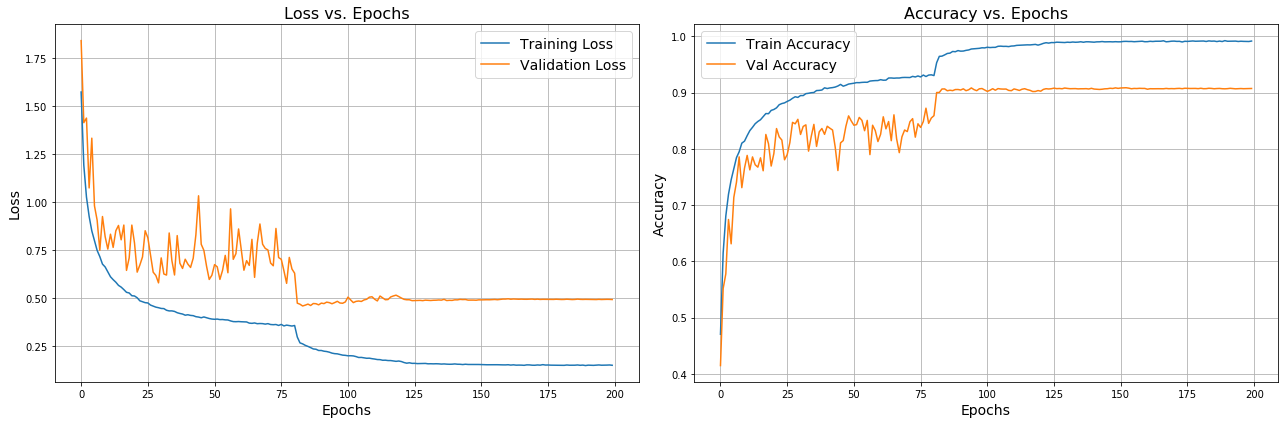

In [17]:
# Visualize the training process
train_loss = resnet_history.history['loss']
train_acc = resnet_history.history['acc']
val_loss = resnet_history.history['val_loss']
val_acc = resnet_history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
fig.savefig('./result/resnet_loss.png', dpi=200)
plt.show()

In [18]:
# Load the saved model
resnet_model = keras.models.load_model('./models/resnet_checkpoint.h5')

# Make predictions
test_pred = resnet_model.predict(test_x)
test_digit = np.argmax(test_pred, axis=1)
test_label = list(map(lambda x: digit2labels[x], test_digit))

idx = list(range(1, 300000 + 1))
df = pd.DataFrame({'id': idx, 'label': test_label})
df.to_csv('./result/resnet_submission.csv', columns=['id', 'label'], index=False)